In [20]:
import pandas as pd

import numpy as np

import os,sys


from shapely.geometry import Point, Polygon

import copy


from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import time


from scipy.stats import pearsonr

import scipy.stats as stats

In [21]:
'''

'Total Number of Shifts', Sum

'Average Order Number', Avg

'Average Shift Duration (sec)', Avg

'Average Occupied Time (sec)', Avg

'First Shift Start Time', No

'Average Occupied Distance(m)' Avg

'''

def Get_sort(a,b,idx):

    a, b = zip(*sorted(zip(a, b)))
    
    if idx==0: 
        return list(a)
    else:  
        return list(b)

def Get_Shift(Startstamp,Endstamp,Duration,Distance):
    
    Result=list()
    
    if len(Startstamp)==1:
        
        Result.append([1,1,Duration[0],Duration[0],Startstamp[0],Endstamp[0],Distance[0]])
        
    else:
        
        s=0
        
        i=0
        
        j=1
        
        order_num=0
        
        occupied_duration=0
        
        occupied_distance=0
        
        while j<len(Startstamp):
            
            order_num+=1
                
            occupied_duration+=Duration[i]

            occupied_distance+=Distance[i]
            
            if Startstamp[j]-Endstamp[i]<3600*2:
                
                if j==len(Startstamp)-1:
                    
                    shift_duration=Endstamp[j]-Startstamp[s]
                    
                    order_num+=1
                
                    occupied_duration+=Duration[j]

                    occupied_distance+=Distance[j]
                    
                    Result.append([1,order_num,shift_duration,occupied_duration,Startstamp[s],Endstamp[j],occupied_distance])
                    
                i+=1
                
                j+=1
                
            else:
                
                shift_duration=Endstamp[i]-Startstamp[s]
                
                Result.append([1,order_num,shift_duration,occupied_duration,Startstamp[s],Endstamp[i],occupied_distance])
                
                order_num=0
                
                occupied_duration=0
                
                occupied_distance=0
                
                s=j
                
                i=j
                
                j+=1
                
    return Result
                
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 

Get_hour=lambda x:int(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[11:13])+float(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[14:16])/60.0

Get_3600=lambda x:round(x/3600.0,2)

Get_10=lambda x:round(x/10.0,2)


In [22]:
Load_path='./Data/GAIA/'

Test_path='./Data/Test/'


In [23]:
dt='20161117'

GPS_Df=pd.read_csv(os.path.join(Load_path,'gps_'+dt+'.csv'),header=None,names=['Driver_id','Order_id',\
                                                                               'Timestamp','Longitude',\
                                                                              'Latitude'])

GPS_Df=GPS_Df.drop_duplicates(subset=['Driver_id','Order_id'])

GPS_Df=GPS_Df.reset_index(drop=True)

GPS_Df=GPS_Df[['Driver_id','Order_id']]


Order_Df=pd.read_csv(os.path.join(Load_path,'order_'+dt+'.csv'),header=None,names=['Order_id','Startstamp','Endstamp',\
                                                                                   'Pickup_Longitude','Pickup_Latitude',\
                                                                                   'Dropoff_Longitude','Dropoff_Latitude'])

Get_distance=lambda lng1,lat1,lng2,lat2:int(Point(lng1,lat1).distance(Point(lng2,lat2))*111000)

Order_Df['Duration']=Order_Df.apply(lambda x:x['Endstamp']-x['Startstamp'],axis=1)

Order_Df['Distance']=Order_Df.apply(lambda x:Get_distance(x['Pickup_Longitude'],x['Pickup_Latitude'],x['Dropoff_Longitude'],x['Dropoff_Latitude']),axis=1)

Order_Df=Order_Df[['Order_id','Startstamp','Endstamp','Duration','Distance']]

Behavior_Df=GPS_Df.merge(Order_Df,on='Order_id',how='left')

Behavior_Df=Behavior_Df.dropna()

Behavior_Df['Startstamp']=Behavior_Df['Startstamp'].astype('int32')

Behavior_Df['Endstamp']=Behavior_Df['Endstamp'].astype('int32')

Behavior_Df=Behavior_Df[['Driver_id','Order_id','Startstamp','Endstamp','Duration','Distance']]

Behavior_Df=Behavior_Df.drop_duplicates(subset=['Driver_id','Order_id'])

Behavior_Df=Behavior_Df.sort_values(by=['Driver_id','Startstamp'])

Behavior_Df=Behavior_Df.reset_index(drop=True)

Stat_Df = pd.DataFrame([])

Stat_Df['Startstamp']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Startstamp'].to_list())

Stat_Df['Endstamp']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Endstamp'].to_list())

Stat_Df['Duration']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Duration'].to_list())

Stat_Df['Distance']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Distance'].to_list())

Stat_Df['Driver_id']=Stat_Df.index

Stat_Df=Stat_Df.reset_index(drop=True)

Stat_Df=Stat_Df[['Driver_id','Startstamp','Endstamp','Duration','Distance']]

Test_Df=copy.deepcopy(Stat_Df)


Test_Df['Transition']=Test_Df.apply(lambda x:Get_Shift(x['Startstamp'],x['Endstamp'],\
                                                      x['Duration'],x['Distance']),axis=1)

Test_Df=Test_Df[['Driver_id','Transition']]

Test_Df=explode(Test_Df,'Transition')


Cols=['Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time', 'End Time','Occupied Distance(m)']

for i in range(len(Cols)):

    Test_Df[Cols[i]]=Test_Df.apply(lambda x:x['Transition'][i],axis=1)


Test_Df=Test_Df[['Driver_id','Start Time','End Time']]

Test_Df['Start Hour']=Test_Df.apply(lambda x:round(Get_hour(x['Start Time']),2),axis=1)

Test_Df['End Hour']=Test_Df.apply(lambda x:round(Get_hour(x['End Time']),2),axis=1)

Test_Df['Active_range']=Test_Df.apply(lambda x:[round(y,1) for y in np.arange(x['Start Hour'],x['End Hour']+0.1,0.1)],axis=1)

Test_Df


,Driver_id,Start Time,End Time,Start Hour,End Hour,Active_range
0,00016e54648071044515d4ff3bd3ae18,1479340451,1479343157,7.90,8.65,"[7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7]"
0,00016e54648071044515d4ff3bd3ae18,1479359987,1479374153,13.32,17.25,"[13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14...."
0,00016e54648071044515d4ff3bd3ae18,1479382555,1479389913,19.58,21.63,"[19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20...."
1,000208036277ccdaff814c3b3646ce3b,1479330085,1479330990,5.02,5.27,"[5.0, 5.1, 5.2, 5.3]"
1,000208036277ccdaff814c3b3646ce3b,1479346590,1479376342,9.60,17.87,"[9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 1..."
2,000253e15f35af82a2296c4be1f18a75,1479393128,1479396386,22.53,23.43,"[22.5, 22.6, 22.7, 22.8, 22.9, 23.0, 23.1, 23...."
3,00031f44d41e80a8753275a3f1d38617,1479347881,1479348506,9.97,10.13,"[10.0, 10.1, 10.2]"
3,00031f44d41e80a8753275a3f1d38617,1479361814,1479365568,13.83,14.87,"[13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14...."
4,00033e9c9931635eff65cc1f3fa9b3bb,1479344923,1479379885,9.13,18.85,"[9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, ..."
5,0003ed034cbb16291336f914ead9b5e2,1479347253,1479360613,9.78,13.50,"[9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5,..."


In [24]:
Validate_Stat=explode(Test_Df,'Active_range')

Validate_Stat=Validate_Stat.rename(columns={'Active_range':'step'})

Validate_Stat=Validate_Stat.groupby('step').count()

Validate_Stat['step']=Validate_Stat.index

Validate_Stat=Validate_Stat.rename(columns={'Driver_id':'Count'})

Validate_Stat=Validate_Stat[['step','Count']]

Validate_Stat=Validate_Stat.reset_index(drop=True)

Validate_Stat=Validate_Stat.sort_values(by='step')

Validate_Stat=Validate_Stat.reset_index(drop=True)

Validate_Stat.to_csv(os.path.join(Test_path,'Validation_'+dt+'.csv'))


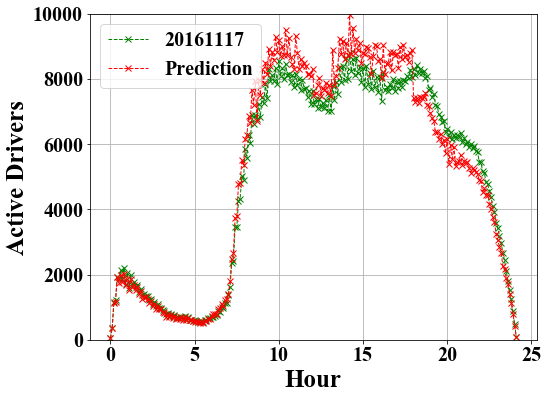

In [25]:
figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]


def Random_sample(mu, sigma, lower, upper, num):
    
    X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return X.rvs(num)


Count_arr = np.array(Validate_Stat['Count'])

num = len(Count_arr)

Random_arr=np.append(Random_sample(0.95, 0.02, 0.8, 1.2, 60),Random_sample(1.09, 0.03, 0.8, 1.2, 120),axis=0)

Random_arr=np.append(Random_arr,Random_sample(0.90, 0.02, 0.8, 1.2,num-180),axis=0)



ax1.plot(Validate_Stat['step'],Count_arr,'g--',linewidth=1,marker='x', label=dt)

ax1.plot(Validate_Stat['step'],Count_arr*Random_arr,'r--',linewidth=1,marker='x', label='Prediction')

ax1.set_ylabel('Active Drivers',font_label)

ax1.set_xlabel('Hour',font_label)

ax1.legend(loc = 'upper left',prop=font_legend)


ax1.set_ylim([0,10000])


plt.grid()

plt.show()